In [1]:
from src.get_from_mongo import get_data
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import numpy as np
import tensorflow as tf
import pickle

In [2]:
id_from_char = {
    'CAPTAIN_FALCON' : 1 ,
    'DONKEY_KONG'    : 2 ,
    'FOX'            : 3 ,
    'GAME_AND_WATCH' : 4 ,
    'KIRBY'          : 5 ,
    'BOWSER'         : 6 ,
    'LINK'           : 7 ,
    'LUIGI'          : 8 ,
    'MARIO'          : 9 ,
    'MARTH'          : 10 ,
    'MEWTWO'         : 11 ,
    'NESS'           : 12 ,
    'PEACH'          : 13 ,
    'PIKACHU'        : 14 ,
    'ICE_CLIMBERS'   : 15 ,
    'JIGGLYPUFF'     : 16 ,
    'SAMUS'          : 17 ,
    'YOSHI'          : 18 ,
    'ZELDA'          : 19 ,
    'SHEIK'          : 20 ,
    'FALCO'          : 21 ,
    'YOUNG_LINK'     : 22 ,
    'DR_MARIO'       : 23 ,
    'ROY'            : 24 ,
    'PICHU'          : 25 ,
    'GANONDORF'      : 26 ,
}

char_from_id = {v:k for k, v in id_from_char.items()}

In [3]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [207]:
def data_generator(clip_collection=collection, # collection containing clips
                   batch_size = 100,
                   skip=None,
                   step=1,
                   repeat=False,
                   mode=None,
                   limit=None,
                   onehot=True):
        
        
        cur = clip_collection.find()
        
        if skip:
            cur.skip(skip)
        
        if limit:
            cur.limit(limit)
            
        while cur.alive:
            
            xi = []
            yi = []
            
            for _ in range(batch_size):
                for _ in range(step):
                    try:
                        clip = next(cur)
                        
                    except StopIteration:
                        if repeat:
                            cur = clip_collection.find()
                            if skip:  cur.skip(skip)
                            if limit: cur.limit(step*limit)
                            clip = next(cur)
                        else:
                            raise
                
                if mode != 'Y':
                    xi.append(pickle.loads(clip['istream']).toarray())
                yi.append(id_from_char[clip['character']])

            xi = np.stack(xi, axis=0)
            
            if onehot:
                yi = tf.one_hot(yi, 26)
            
            if mode == 'X' or mode == 'x':
                yield xi
                
            elif mode == 'Y' or mode == 'y':
                yield yi
                
            elif mode:
                raise ValueError("mode must be 'X' or 'Y' or None")

            else:
                yield xi, yi

In [6]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.activations import swish

import tensorflow_addons as tfa

top_8_accuracy = keras.metrics.TopKCategoricalAccuracy(k=8, name='top 8 accuracy')

focal_loss = tfa.losses.SigmoidFocalCrossEntropy()

In [7]:
model = Sequential()

# first conv layer
# sees .5s
model.add(Conv1D(150, #num of features extracted from istream
                 30, #number of frames filter can see at once
                 activation=swish))

model.add(SpatialDropout1D(.2))
model.add(MaxPooling1D(pool_size=2))

# sees 1s
model.add(Conv1D(80,
                 30,
                 activation=swish))

model.add(SpatialDropout1D(.2))
model.add(MaxPooling1D(pool_size=2))

# sees 2s
model.add(Conv1D(80,
                 30,
                 activation=swish))

# sees whole 30s, takes max pool
model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(80, activation=swish))

model.add(Dropout(.2))

model.add(Dense(80, activation=swish))

model.add(Dropout(.2))

# final output layer
model.add(Dense(26, activation='softmax'))
                
model.compile(loss=focal_loss,
              optimizer='adam',
              metrics=['accuracy', top_8_accuracy])

# Training

In [8]:
data = data_generator(batch_size=100, skip=100000, step=101, repeat=True) # keep first 100000 clips as test data

In [9]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=5, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

Epoch 1/5
500/500 [==============================] - 1420s 3s/step - loss: 0.3245 - accuracy: 0.5088 - top 8 accuracy: 0.9084
Epoch 2/5
500/500 [==============================] - 1414s 3s/step - loss: 0.2023 - accuracy: 0.7124 - top 8 accuracy: 0.9394
Epoch 3/5
500/500 [==============================] - 1409s 3s/step - loss: 0.1562 - accuracy: 0.7767 - top 8 accuracy: 0.9520
Epoch 4/5
500/500 [==============================] - 1426s 3s/step - loss: 0.1323 - accuracy: 0.8108 - top 8 accuracy: 0.9597
Epoch 5/5
500/500 [==============================] - 1420s 3s/step - loss: 0.1198 - accuracy: 0.8286 - top 8 accuracy: 0.9631

Test score: 0.091
Test accuracy: 87%
Test test top 8 accuracy: 97%


In [79]:
data = data_generator(batch_size=100, skip=100001, step=101, repeat=True) # keep first 100000 clips as test data

In [80]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=5, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

Epoch 1/5
500/500 [==============================] - 1415s 3s/step - loss: 0.1074 - accuracy: 0.8440 - top 8 accuracy: 0.9662
Epoch 2/5
500/500 [==============================] - 1411s 3s/step - loss: 0.0990 - accuracy: 0.8552 - top 8 accuracy: 0.9683
Epoch 3/5
500/500 [==============================] - 1410s 3s/step - loss: 0.0940 - accuracy: 0.8616 - top 8 accuracy: 0.9676
Epoch 4/5
500/500 [==============================] - 1410s 3s/step - loss: 0.0862 - accuracy: 0.8713 - top 8 accuracy: 0.9701
Epoch 5/5
500/500 [==============================] - 1411s 3s/step - loss: 0.0840 - accuracy: 0.8749 - top 8 accuracy: 0.9709

Test score: 0.066
Test accuracy: 90%
Test test top 8 accuracy: 97%


In [287]:
data = data_generator(batch_size=100, skip=100002, step=101, repeat=True) # keep first 100000 clips as test data

In [146]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=5, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

Epoch 1/5
500/500 [==============================] - 1412s 3s/step - loss: 0.0798 - accuracy: 0.8806 - top 8 accuracy: 0.9715
Epoch 2/5
500/500 [==============================] - 1412s 3s/step - loss: 0.0762 - accuracy: 0.8858 - top 8 accuracy: 0.9729
Epoch 3/5
500/500 [==============================] - 1408s 3s/step - loss: 0.0738 - accuracy: 0.8887 - top 8 accuracy: 0.9734
Epoch 4/5
500/500 [==============================] - 1411s 3s/step - loss: 0.0726 - accuracy: 0.8907 - top 8 accuracy: 0.9723
Epoch 5/5
500/500 [==============================] - 1411s 3s/step - loss: 0.0699 - accuracy: 0.8941 - top 8 accuracy: 0.9745

Test score: 0.052
Test accuracy: 92%
Test test top 8 accuracy: 98%


In [148]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=1, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

500/500 [==============================] - 1407s 3s/step - loss: 0.0684 - accuracy: 0.8962 - top 8 accuracy: 0.9734

Test score: 0.045
Test accuracy: 92%
Test test top 8 accuracy: 98%


In [149]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=1, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

500/500 [==============================] - 1407s 3s/step - loss: 0.0673 - accuracy: 0.8961 - top 8 accuracy: 0.9750

Test score: 0.047
Test accuracy: 92%
Test test top 8 accuracy: 98%


In [ ]:
data = data_generator(batch_size=100, skip=100002, step=11, repeat=True) # keep first 100000 clips as test data

In [288]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=5, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')  # this is the one we care about

Epoch 1/5
500/500 [==============================] - 1220s 2s/step - loss: 0.0654 - accuracy: 0.8997 - top 8 accuracy: 0.9748
Epoch 2/5
500/500 [==============================] - 1223s 2s/step - loss: 0.0620 - accuracy: 0.9032 - top 8 accuracy: 0.9762
Epoch 3/5
500/500 [==============================] - 1219s 2s/step - loss: 0.0629 - accuracy: 0.9018 - top 8 accuracy: 0.9752
Epoch 4/5
500/500 [==============================] - 1212s 2s/step - loss: 0.0602 - accuracy: 0.9043 - top 8 accuracy: 0.9755
Epoch 5/5
500/500 [==============================] - 1221s 2s/step - loss: 0.0611 - accuracy: 0.9068 - top 8 accuracy: 0.9756

Test score: 0.048
Test accuracy: 92%
Test test top 8 accuracy: 98%


# Testing

In [290]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [291]:
# X_test, Y_test = next(data_generator(batch_size=5000, step = 5))

In [292]:
data_test = data_generator(clip_collection=collection,
                           batch_size = 100,
                           skip=None,
                           step=7,
                           repeat=True,
                           limit=100000)

X_test = data_generator(clip_collection=collection,
                        batch_size = 100,
                        skip=None,
                        step=7,
                        repeat=True,
                        mode='x',
                        limit=100000)

Y_test = data_generator(clip_collection=collection,
                        batch_size = 100,
                        skip=None,
                        step=7,
                        repeat=True,
                        mode='y',
                        limit=100000)

y_test = data_generator(clip_collection=collection,
                        batch_size = 100,
                        skip=None,
                        step=7,
                        repeat=True,
                        mode='y',
                        limit=100000,
                        onehot=False)

steps = 100

In [293]:
# pred = np.argmax(model.predict(X_test, steps=steps), axis = 1)
# labels = np.concatenate([next(y_test) for _ in range(steps)])

In [294]:
score = model.evaluate(data_test, steps=steps, verbose=1)

100/100 [==============================] - 70s 697ms/step - loss: 0.0446 - accuracy: 0.9254 - top 8 accuracy: 0.9797


In [295]:
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 


Test score: 0.045
Test accuracy: 93%
Test test top 8 categorical accuracy: 98%


In [296]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

pred = np.argmax(model.predict(X_test, steps=steps, verbose=1), axis = 1)
labels = np.concatenate([next(y_test) for _ in range(steps)])

conf_matrix = get_conf_matrix(labels, pred)

100/100 [==============================] - 70s 697ms/step


In [297]:
char_id = 0

In [323]:
char_id += 1
row = conf_matrix[char_id, :]
sorted_row_indices = np.argsort(row)[::-1]
correct = conf_matrix[char_id, char_id]
total = np.sum(row)
recall = correct/total if total else 0
recalls[char_id] = recall
print(f'{char_from_id[char_id]}')
print(f'Recall: {round(100*recall, 1)}%\n ------------------')
for i in sorted_row_indices:
    if i > 0:
        print(f'{char_from_id[i]} : {row[i]}')

GANONDORF
Recall: 0.0%
 ------------------
CAPTAIN_FALCON : 100.0
FOX : 7.0
LINK : 6.0
YOSHI : 4.0
GAME_AND_WATCH : 3.0
JIGGLYPUFF : 3.0
PIKACHU : 3.0
SHEIK : 2.0
PEACH : 1.0
MARTH : 1.0
FALCO : 1.0
DONKEY_KONG : 0.0
KIRBY : 0.0
BOWSER : 0.0
LUIGI : 0.0
MARIO : 0.0
GANONDORF : 0.0
MEWTWO : 0.0
NESS : 0.0
PICHU : 0.0
ICE_CLIMBERS : 0.0
SAMUS : 0.0
ZELDA : 0.0
YOUNG_LINK : 0.0
DR_MARIO : 0.0
ROY : 0.0


In [324]:
for i, acc in {k: v for k, v in sorted(recalls.items(), key=lambda item: -item[1])}.items():
    print(f'{char_from_id[i]}:\t{round(100*acc, 1)}%')

FOX:	97.9%
SHEIK:	97.5%
MARTH:	97.3%
FALCO:	97.3%
PEACH:	95.9%
CAPTAIN_FALCON:	95.1%
PIKACHU:	93.8%
JIGGLYPUFF:	93.1%
SAMUS:	91.3%
YOSHI:	86.3%
ICE_CLIMBERS:	84.5%
LUIGI:	81.9%
LINK:	71.7%
DONKEY_KONG:	68.2%
DR_MARIO:	60.0%
GAME_AND_WATCH:	51.6%
YOUNG_LINK:	47.4%
KIRBY:	30.0%
NESS:	22.7%
ZELDA:	20.9%
ROY:	19.2%
MEWTWO:	14.3%
MARIO:	5.0%
BOWSER:	0.0%
PICHU:	0.0%
GANONDORF:	0.0%


In [325]:
char_id = 0

In [351]:
char_id += 1
col = conf_matrix[:, char_id]
sorted_col_indices = np.argsort(col)[::-1]
correct = conf_matrix[char_id, char_id]
total = np.sum(col)
precision = correct/total if total else 0
precisions[char_id] = precision
print(f'{char_from_id[char_id]}')
print(f'Precision: {round(100*precision, 1)}%\n ------------------')
for i in sorted_col_indices:
    if i > 0:
        print(f'{char_from_id[i]} : {col[i]}')

GANONDORF
Precision: 0%
 ------------------
GANONDORF : 0.0
NESS : 0.0
CAPTAIN_FALCON : 0.0
DONKEY_KONG : 0.0
FOX : 0.0
GAME_AND_WATCH : 0.0
KIRBY : 0.0
BOWSER : 0.0
LINK : 0.0
LUIGI : 0.0
MARIO : 0.0
MARTH : 0.0
MEWTWO : 0.0
PEACH : 0.0
PICHU : 0.0
PIKACHU : 0.0
ICE_CLIMBERS : 0.0
JIGGLYPUFF : 0.0
SAMUS : 0.0
YOSHI : 0.0
ZELDA : 0.0
SHEIK : 0.0
FALCO : 0.0
YOUNG_LINK : 0.0
DR_MARIO : 0.0
ROY : 0.0


In [352]:
for i, acc in {k: v for k, v in sorted(precisions.items(), key=lambda item: -item[1])}.items():
    print(f'{char_from_id[i]}:\t{round(100*acc, 1)}%')

MARIO:	100.0%
MEWTWO:	100.0%
PEACH:	99.1%
FALCO:	98.1%
SAMUS:	96.1%
FOX:	94.1%
MARTH:	93.6%
ICE_CLIMBERS:	92.2%
DONKEY_KONG:	91.8%
LUIGI:	90.5%
SHEIK:	90.0%
JIGGLYPUFF:	89.9%
YOSHI:	88.0%
KIRBY:	85.7%
CAPTAIN_FALCON:	85.4%
ROY:	83.3%
PIKACHU:	81.9%
GAME_AND_WATCH:	80.0%
LINK:	77.6%
YOUNG_LINK:	75.0%
ZELDA:	73.7%
NESS:	71.4%
DR_MARIO:	54.5%
BOWSER:	0.0%
PICHU:	0%
GANONDORF:	0%


In [286]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 150)         58650     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 150)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 80)          360080    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 80)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 80)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 80)          1

In [276]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [353]:
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=id_from_char.keys(), columns=id_from_char.keys())

<AxesSubplot:>

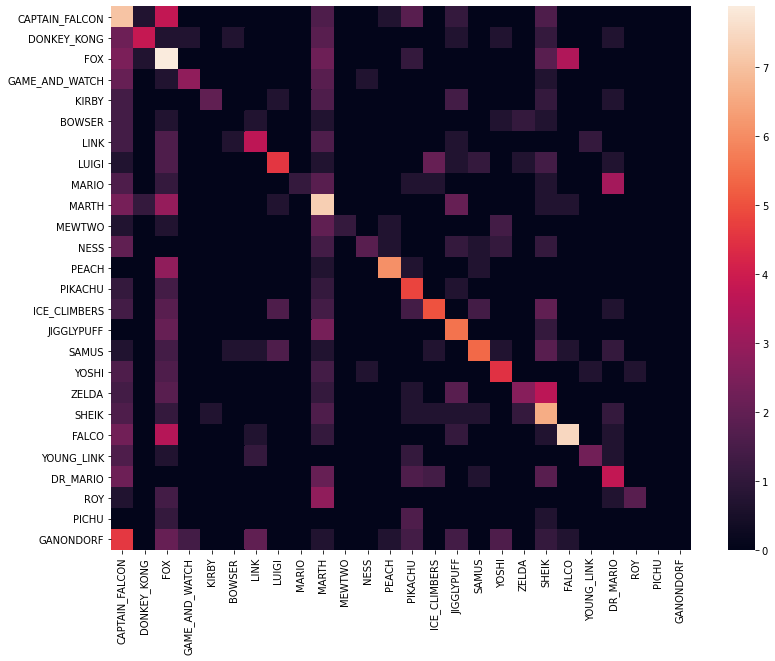

In [354]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log( 1 + conf_df), annot=False, ax=ax, square=False)

In [355]:
model.save('models/cnn_model')